In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot
import json
import rasterio
from rasterio import mask
import os
from skimage import morphology

In [2]:
def jsonName(tifname):
    return "spacenetroads_AOI_2_Vegas_img" + tifname[30:-4] + ".geojson"

def roadName(tifname):
    return "road" + tifname[30:-4] + ".tif"

In [3]:
def roadsFromJSON(dataset, json_file):
    if os.path.isfile(json_file):
        with open(json_file, 'r') as f:
            readjson = json.load(f)
        if len(readjson) > 0:
            shapes = [shape['geometry'] for shape in readjson['features']]
        else:
            shapes = []
    else:
        shapes = []
    if(len(shapes) > 0):
        img = rasterio.features.rasterize(shapes, transform = dataset.transform,
                                     out_shape = (1300, 1300), default_value = 1.0, fill = 0, all_touched = True)
    else:
        img = np.zeros((1300, 1300),np.int16)
    return img.astype(int)

In [4]:
def broadRoadsFromJSON(dataset, json_file, w = 10):
    img = roadsFromJSON(dataset, json_file)
    return morphology.binary_dilation(img, selem=morphology.disk(w)).astype(np.int16)

In [5]:
def createRoadTif(out_file, dataset, json_file, w=10):
    img = broadRoadsFromJSON(dataset, json_file, w)
    out_dataset = rasterio.open(out_file, 'w', driver='GTiff',
                                height=img.shape[0], width=img.shape[1],
                                count=1, dtype=img.dtype,
                                crs=dataset.crs, transform=dataset.transform)
    out_dataset.write(img, 1)
    out_dataset.close()

In [6]:
files = []
dirname = os.getcwd() + "/spacenet_sample/AOI_2_Vegas_Train/RGB-PanSharpen/"
jsondirname = os.getcwd() + "/spacenet_sample/AOI_2_Vegas_Train/geojson/spacenetroads/"
roaddirname = os.getcwd() + "/spacenet_sample/AOI_2_Vegas_Train/roads/"

In [7]:
for filename in os.listdir(dirname):
    if(filename.endswith(".tif")):
        outf = roaddirname + roadName(filename)
        jf = jsondirname + jsonName(filename)
        if not os.path.isfile(outf):
            current = rasterio.open("spacenet_sample/AOI_2_Vegas_Train/RGB-PanSharpen/" + filename, "r")
            print(filename)
            createRoadTif(outf, current, jf, w=10)
            current.close()

RGB-PanSharpen_AOI_2_Vegas_img1458.tif


In [8]:
matplotlib.rcParams['figure.figsize'] = [12, 12]

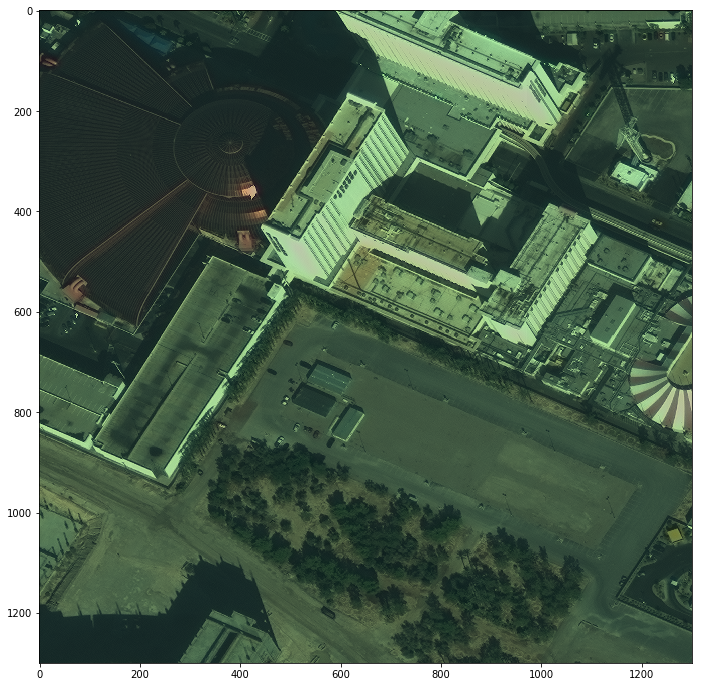

In [9]:
dataset = rasterio.open(dirname + "RGB-PanSharpen_AOI_2_Vegas_img1458.tif")
pyplot.imshow(dataset.read().transpose(1,2,0) / 2048)

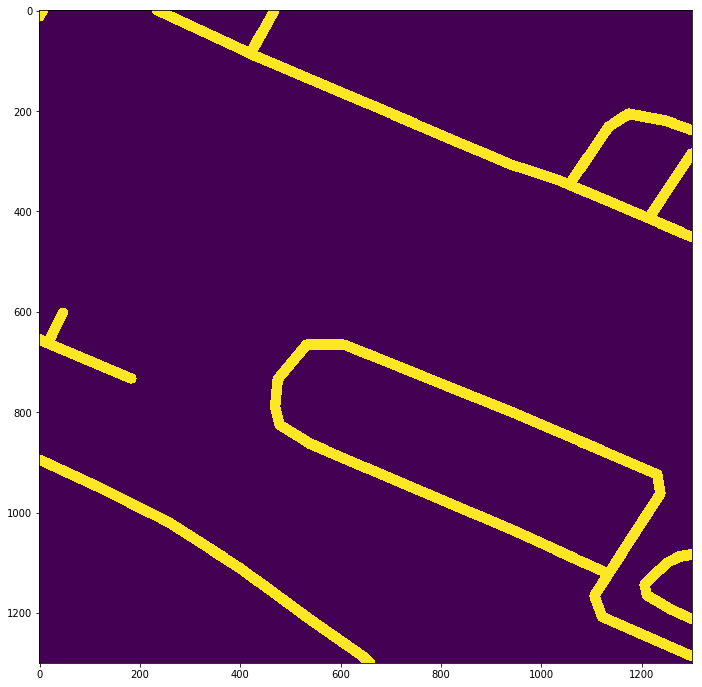

In [10]:
dataset = rasterio.open(roaddirname + roadName("RGB-PanSharpen_AOI_2_Vegas_img1458.tif"))
pyplot.imshow(dataset.read()[0])